In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import linregress
from datetime import timedelta
%matplotlib inline

#### Load data from published sources on lockdown and work

In [9]:
ld_countries = pd.read_excel('R_W_R_L values.xlsx')
work_R = pd.read_excel('R_W_R_L values.xlsx','R_Work')

#### Load raw data from ECDC and from the New York Times

In [3]:
# load data
data = pd.read_csv('https://opendata.ecdc.europa.eu/covid19/casedistribution/csv')
# format dates
data.dateRep = pd.to_datetime(data.dateRep,format='%d/%m/%Y')
data.set_index('dateRep',inplace=True)

In [7]:
# format lockdown date
ld_countries['Lockdown date']=pd.to_datetime(ld_countries['Lockdown date'])
country_ld = ld_countries[['Country','Lockdown date']].drop_duplicates()
# filter only countries with lockdown
data_for_ld = data[(data['countriesAndTerritories'].isin(country_ld.Country))]
# take only dates that are 2 weeks after the lockdown
data_for_ld = data_for_ld.groupby('countriesAndTerritories').apply(lambda x: x[x.index-timedelta(14) > (country_ld.loc[country_ld.Country==x['countriesAndTerritories'].unique()[0],'Lockdown date'].values[0])]).drop('countriesAndTerritories',axis=1).reset_index()
# format dates
data_for_ld.dateRep = pd.to_datetime(data_for_ld.dateRep,format='%d/%m/%Y')
data_for_ld.set_index('dateRep',inplace=True)

In [8]:
us_counties = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv')
nyc_data = us_counties[us_counties.county=='New York City']
nyc_data['dateRep'] = pd.to_datetime(nyc_data.date).values
nyc_data = nyc_data.set_index('dateRep')[['cases','deaths']]
nyc_data = nyc_data[['cases','deaths']].diff().dropna()
nyc_data = nyc_data[nyc_data.index-timedelta(14) > ld_countries.loc[ld_countries.Country=='New York City','Lockdown date'].values[0]]
nyc_data['countriesAndTerritories'] = 'New York City'
data_for_ld = data_for_ld.append(nyc_data)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/yinonbaron/.local/lib/python3.6/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [23]:
def get_slope(array):
    r = array.dropna()
    slope, intercept, r_value, p_value, std_err = linregress((r.index-r.index[0]).days,np.log(r))
    return slope
def get_slope_std(array):
    r = array.dropna()
    slope, intercept, r_value, p_value, std_err = linregress((r.index-r.index[0]).days,np.log(r))
    return std_err

def filter_country_work(data):
    smooth = data.rolling(window=7).mean()
    case_slope = smooth.rolling(window=4*7,center=True)['cases'].agg({'slope':get_slope,'std':get_slope_std})
    case_slope_min = case_slope['slope']-1.96*case_slope['std']
    case_slope_max = case_slope['slope']+1.96*case_slope['std']
    case_rising = any(case_slope_min>0)
    deaths_slope = smooth.rolling(window=4*7,center=True)['deaths'].agg({'slope':get_slope,'std':get_slope_std})
    deaths_slope_min = deaths_slope['slope']-1.96*deaths_slope['std']
    deaths_slope_max = deaths_slope['slope']+1.96*deaths_slope['std']
    deaths_rising = any(deaths_slope_min>0)
    smooth_apr = smooth[smooth.index.month == 4]
    apr_res = smooth_apr['cases'].agg({'slope':get_slope,'std':get_slope_std})
    apr_res_min_case = apr_res['slope']-1.96*apr_res['std']
    apr_res_max_case = apr_res['slope']+1.96*apr_res['std']
    apr_res_d = smooth_apr['deaths'].agg({'slope':get_slope,'std':get_slope_std})
    apr_res_min_d = apr_res_d['slope']-1.96*apr_res_d['std']
    apr_res_max_d = apr_res_d['slope']+1.96*apr_res_d['std']
    if all([case_rising,deaths_rising]):
        return pd.Series([apr_res_min_case,
                          apr_res_max_case,
                          apr_res_min_d,
                          apr_res_max_d],
                          index=['case slope min','case slope max','death slope min','death slope max'])
    elif data.name == 'Singapore':
        return pd.Series([apr_res_min_case,
                          apr_res_max_case,
                          np.nan,
                          np.nan],
                          index=['case slope min','case slope max','death slope min','death slope max'])
    else:
        return None
    
def filter_country_lockdown(data):
    smooth = data.rolling(window=7).mean()
    case_slope = smooth.rolling(window=4*7,center=True)['cases'].agg({'slope':get_slope,'std':get_slope_std})
    case_slope_min = case_slope['slope']-1.96*case_slope['std']
    case_slope_max = case_slope['slope']+1.96*case_slope['std']
    case_rising = any(case_slope_max<0)
    deaths_slope = smooth.rolling(window=4*7,center=True)['deaths'].agg({'slope':get_slope,'std':get_slope_std})
    deaths_slope_min = deaths_slope['slope']-1.96*deaths_slope['std']
    deaths_slope_max = deaths_slope['slope']+1.96*deaths_slope['std']
    deaths_rising = any(deaths_slope_max<0)
    if all([case_rising,deaths_rising]):
        
        return pd.Series([case_slope_min[case_slope_min<0].iloc[0],
                          case_slope_max[case_slope_min<0].iloc[0],
                          case_slope_max[case_slope_min<0].iloc[:1].index,
                          deaths_slope_min[deaths_slope_min<0].iloc[0],
                          deaths_slope_max[deaths_slope_min<0].iloc[0],
                          deaths_slope_max[deaths_slope_min<0].iloc[:1].index],
                          index=['case slope min','case slope max','case date','death slope min','death slope max','death date'])
    else:
        return None
def s_to_R(r):
    return np.exp(r*3.96-0.5*(r*4.75)**2)
def s_to_R_MGF(r,mu=5,std=1.9):
    a = (mu/std)**2
    b = mu/(std)**2
    return (1+r/b)**a

#### Analyze data from raw data
##### For work countries

In [12]:
work_list = ['Sweden','Russia','Japan','Singapore']
work_data = data[data.countriesAndTerritories.isin(work_list)]
work_countries = work_data.groupby('countriesAndTerritories').apply(filter_country_work)
work_countries['case slope mean'] = work_countries[['case slope min','case slope max']].mean(axis=1)
work_countries['death slope mean'] = work_countries[['death slope min','death slope max']].mean(axis=1)

##### For lockdown countries

In [18]:
ld_filt = data_for_ld.groupby('countriesAndTerritories').apply(filter_country_lockdown)
ld_filt.dropna(axis=0,inplace=True)
ld_filt['case slope mean'] = ld_filt[['case slope min','case slope max']].mean(axis=1)
ld_filt['death slope mean'] = ld_filt[['death slope min','death slope max']].mean(axis=1)

#### Plot results
##### Figure 1 - $R_e$

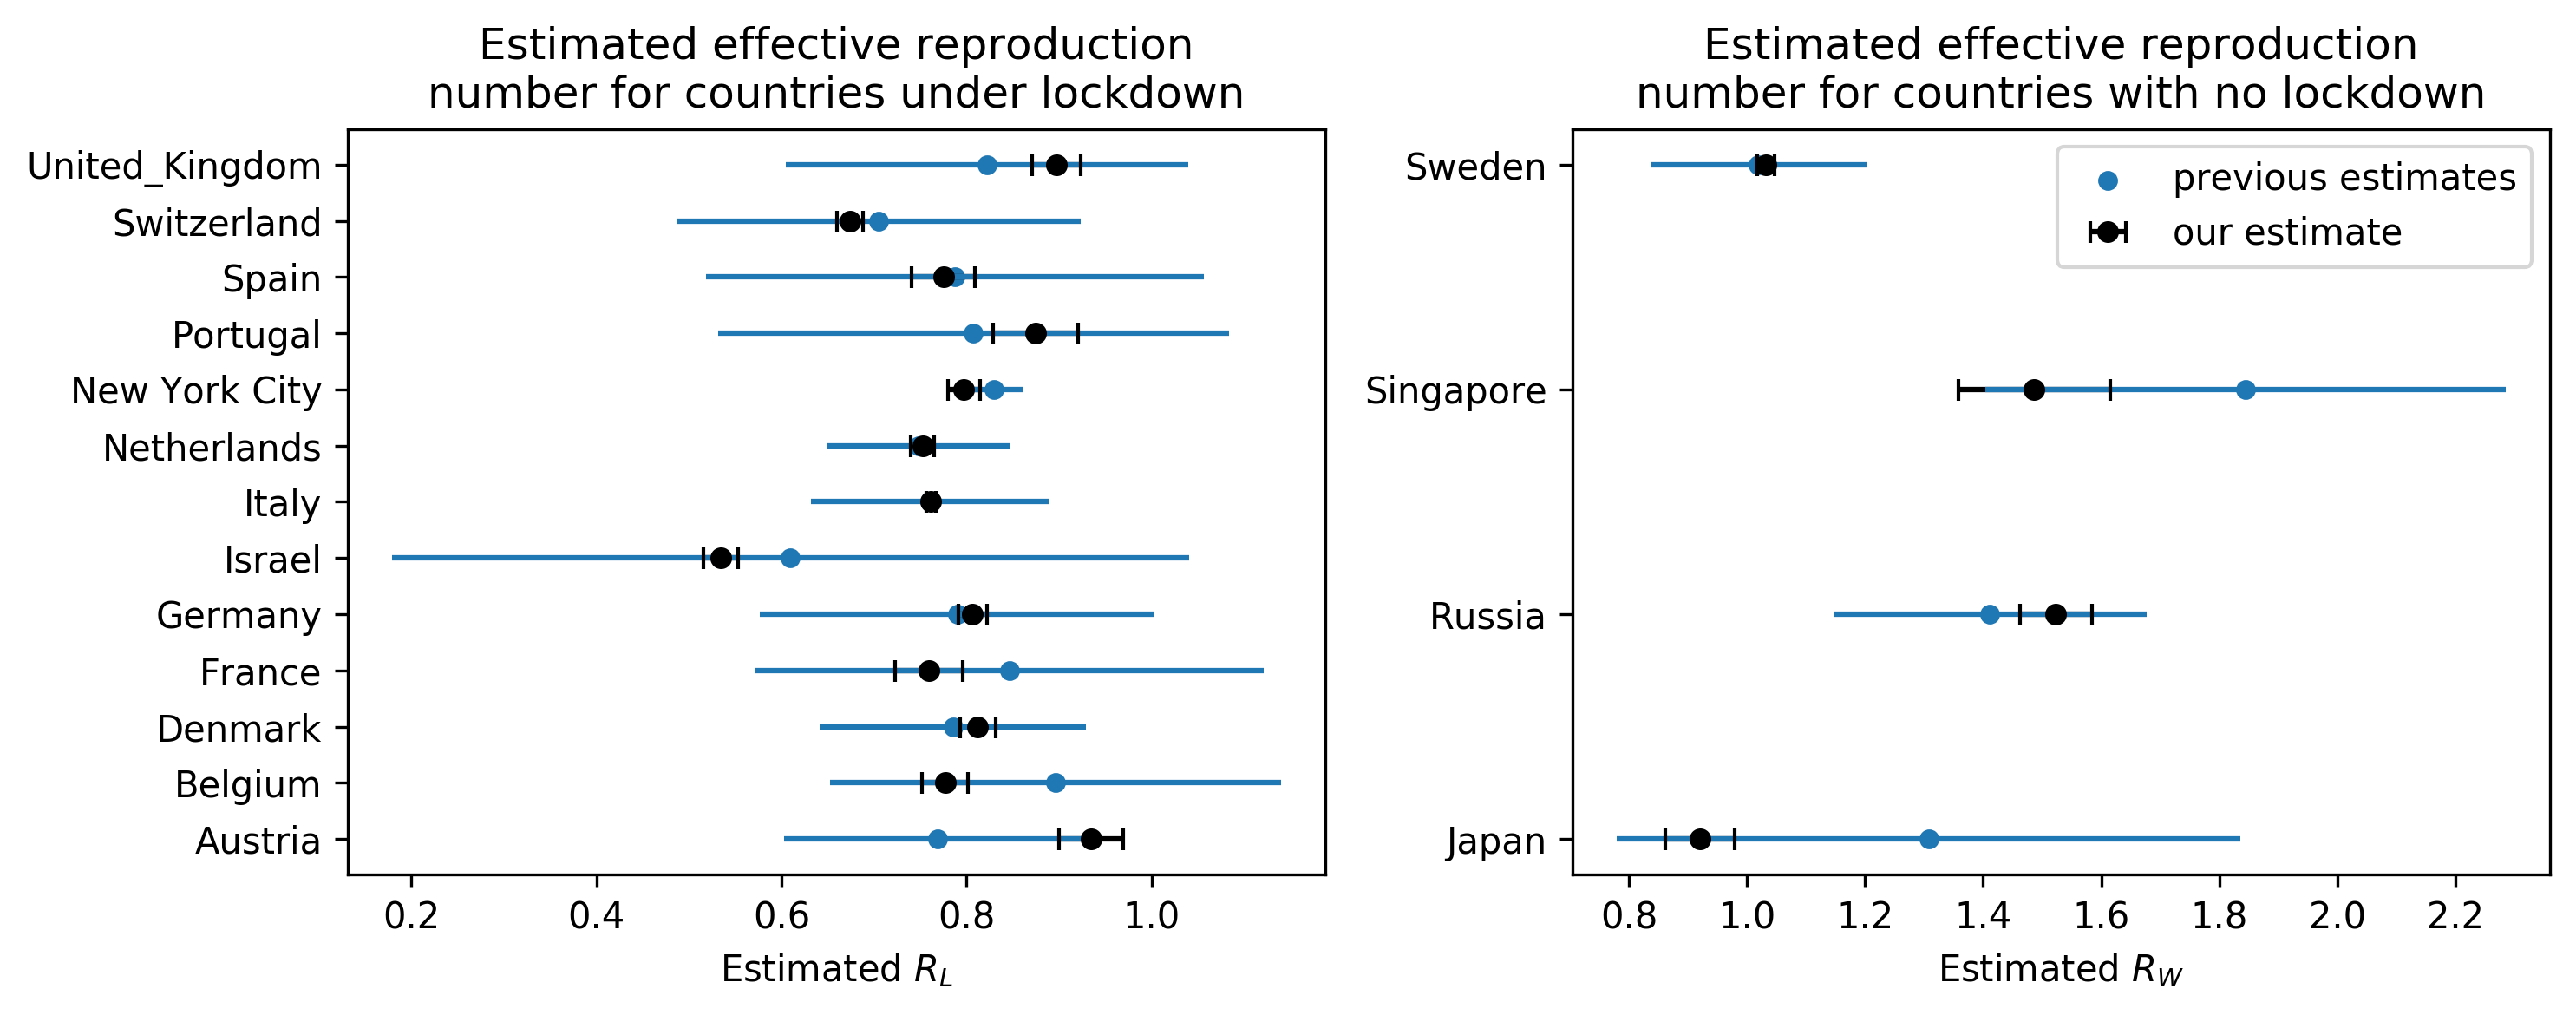

In [46]:
fig, axes = plt.subplots(1,2,dpi=300,figsize=(10,4))
std = s_to_R_MGF(ld_filt['case slope mean'])-s_to_R_MGF(ld_filt['case slope min'])
ax = plt.subplot(1,2,1)
plt.errorbar(y=range(len(ld_filt)),x=s_to_R_MGF(ld_filt['case slope mean']),xerr= std,fmt='.',ecolor='k',color='k',capsize=3,markersize=10)
plt.yticks(range(len(ld_filt)),labels=ld_filt.index);

c_dict = {x:y for x,y in zip(ld_filt.index,range(len(ld_filt)))}
ld_countries['x'] = ld_countries['Country'].map(c_dict)
meanv = ld_countries.groupby('x')['Mean R(t)'].mean()
minv = ld_countries.groupby('x')['R(t) lower value'].mean()
maxv= ld_countries.groupby('x')['R(t) upper value'].mean()
std = np.concatenate([(meanv-minv).values[np.newaxis],(maxv-meanv).values[np.newaxis]],axis=0)
meanv.reset_index().plot.scatter(y='x',x='Mean R(t)',xerr=std,ax=ax)
ax.set_xlabel(xlabel='Estimated $R_L$')
ax.set_ylabel('')

plt.title('Estimated effective reproduction\nnumber for countries under lockdown')

ax2 = plt.subplot(1,2,2)
std = s_to_R_MGF(work_countries['case slope mean'])-s_to_R_MGF(work_countries['case slope min'])
plt.errorbar(y=range(len(work_countries)),x=s_to_R_MGF(work_countries['case slope mean']),xerr= std,fmt='.',ecolor='k',color='k',capsize=3,markersize=10)
plt.yticks(range(len(work_countries)),labels=work_countries.index);

c_dict = {x:y for x,y in zip(work_countries.index,range(len(work_countries)))}
work_R['x'] = work_R['Country'].map(c_dict)
meanv = work_R.groupby('x')['Mean R(t)'].mean()
minv = work_R.groupby('x')['R(t) lower value'].mean()
maxv= work_R.groupby('x')['R(t) upper value'].mean()
std = np.concatenate([(meanv-minv).values[np.newaxis],(maxv-meanv).values[np.newaxis]],axis=0)
meanv.reset_index().plot.scatter(y='x',x='Mean R(t)',xerr=std,ax=ax2)
ax2.set_xlabel(xlabel='Estimated $R_W$')
ax2.set_ylabel('')
ax2.legend(['previous estimates','our estimate'],bbox_to_anchor=[1,1])
plt.title('Estimated effective reproduction\nnumber for countries with no lockdown')
plt.tight_layout()
plt.savefig('Figure1.png',dpi=300)


##### Fig. 2 daily percentage change in cases and deaths

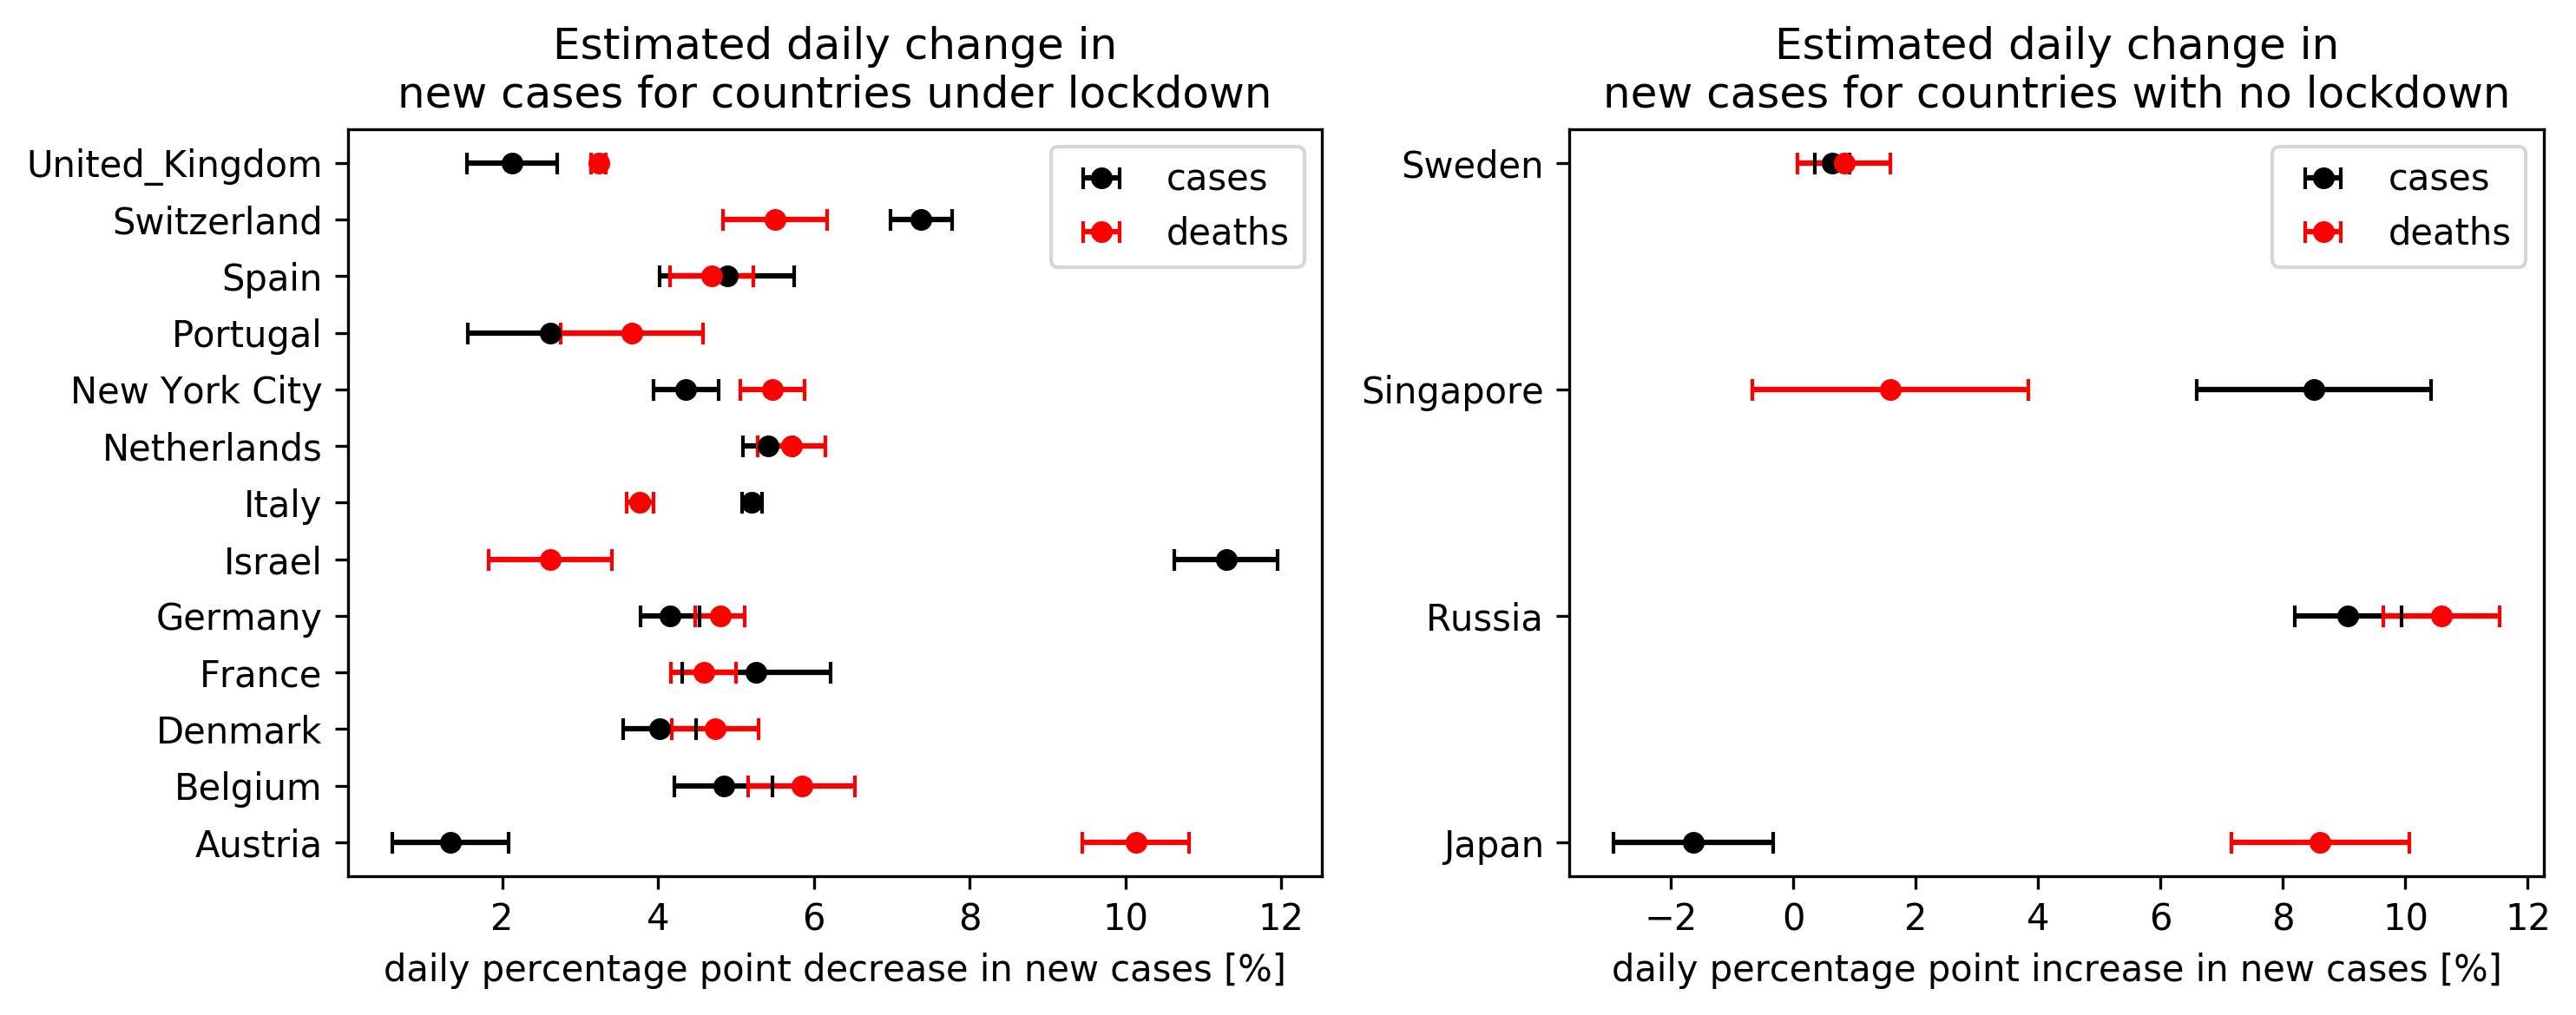

In [45]:
fig, axes = plt.subplots(1,2,dpi=300,figsize=(10,4))
ax = plt.subplot(1,2,1)
std = (ld_filt['case slope mean']-ld_filt['case slope min'])
std_d = (ld_filt['death slope mean']-ld_filt['death slope min'])
plt.errorbar(y=range(len(ld_filt)),x=(1-np.exp(ld_filt['case slope mean']))*100,xerr= (1-np.exp(std))*100,fmt='.',ecolor='k',color='k',capsize=3,markersize=10)
plt.errorbar(y=range(len(ld_filt)),x=(1-np.exp(ld_filt['death slope mean']))*100,xerr= (1-np.exp(std_d))*100,fmt='.',ecolor='r',color='r',capsize=3,markersize=10)
# plt.xlim(0,0.1)
plt.yticks(range(len(ld_filt)),labels=ld_filt.index);
plt.xlabel('daily percentage point decrease in new cases [%]')
plt.title('Estimated daily change in\nnew cases for countries under lockdown')
plt.legend(['cases','deaths'])

ax2 = plt.subplot(1,2,2)
std = (work_countries['case slope mean']-work_countries['case slope min'])
std_d = (work_countries['death slope mean']-work_countries['death slope min'])
plt.errorbar(y=range(len(work_countries)),x=(np.exp(work_countries['case slope mean'])-1)*100,xerr= (np.exp(std)-1)*100,fmt='.',ecolor='k',color='k',capsize=3,markersize=10)
plt.errorbar(y=range(len(work_countries)),x=(np.exp(work_countries['death slope mean'])-1)*100,xerr= (np.exp(std_d)-1)*100,fmt='.',ecolor='r',color='r',capsize=3,markersize=10)
# plt.xlim(0,0.1)
plt.yticks(range(len(work_countries)),labels=work_countries.index);
plt.xlabel('daily percentage point increase in new cases [%]')
plt.title('Estimated daily change in\nnew cases for countries with no lockdown')
plt.legend(['cases','deaths'])
plt.tight_layout()
plt.savefig('Figure2.png',dpi=300)

#### Figure 2 - $R_{eff}$ - lockdown

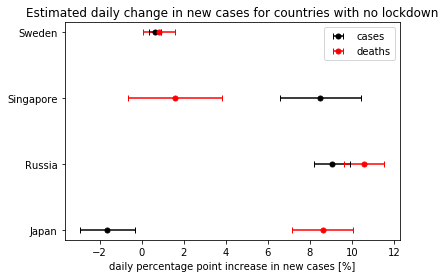

In [21]:
std = (work_countries['case slope mean']-work_countries['case slope min'])
std_d = (work_countries['death slope mean']-work_countries['death slope min'])
plt.errorbar(y=range(len(work_countries)),x=(np.exp(work_countries['case slope mean'])-1)*100,xerr= (np.exp(std)-1)*100,fmt='.',ecolor='k',color='k',capsize=3,markersize=10)
plt.errorbar(y=range(len(work_countries)),x=(np.exp(work_countries['death slope mean'])-1)*100,xerr= (np.exp(std_d)-1)*100,fmt='.',ecolor='r',color='r',capsize=3,markersize=10)
# plt.xlim(0,0.1)
plt.yticks(range(len(work_countries)),labels=work_countries.index);
plt.xlabel('daily percentage point increase in new cases [%]')
plt.title('Estimated daily change in new cases for countries with no lockdown')
plt.legend(['cases','deaths'])
plt.savefig('figure3.png',dpi=300)

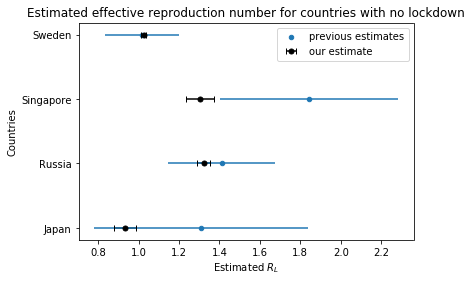

In [22]:
std = s_to_R_MGF(work_countries['case slope mean'])-s_to_R_MGF(work_countries['case slope min'])
ax = plt.subplot(1,1,1)
plt.errorbar(y=range(len(work_countries)),x=s_to_R_MGF(work_countries['case slope mean']),xerr= std,fmt='.',ecolor='k',color='k',capsize=3,markersize=10)
plt.yticks(range(len(work_countries)),labels=work_countries.index);

c_dict = {x:y for x,y in zip(work_countries.index,range(len(work_countries)))}
work_R['x'] = work_R['Country'].map(c_dict)
meanv = work_R.groupby('x')['Mean R(t)'].mean()
minv = work_R.groupby('x')['R(t) lower value'].mean()
maxv= work_R.groupby('x')['R(t) upper value'].mean()
std = np.concatenate([(meanv-minv).values[np.newaxis],(maxv-meanv).values[np.newaxis]],axis=0)
meanv.reset_index().plot.scatter(y='x',x='Mean R(t)',xerr=std,ax=ax)
ax.set_xlabel(xlabel='Estimated $R_L$')
ax.set_ylabel('Countries')
ax.legend(['previous estimates','our estimate'],bbox_to_anchor=[1,1])
plt.title('Estimated effective reproduction number for countries with no lockdown')
plt.savefig('figure4.png',dpi=300)